## Potato Disease Detection -  CNN Model Training


In [1]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import shutil
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: []


## 1. Dataset Preparation
Split the dataset into Training (70%), Validation (15%), and Testing (15%)

In [ ]:
source_dir = r"c:\Users\sarva\Downloads\Minor-project\dataset\PlantVillage"
target_dir = r"c:\Users\sarva\Downloads\Minor-project\dataset\PlantVillage_split"

# Split ratios: train, validation, test
split_ratio = [0.7, 0.15, 0.15]  # 70% train, 15% val, 15% test
splits = ['Training', 'Validation', 'Testing']

def split_dataset(source_dir, target_dir, split_ratio, splits):
    """Split dataset into train/val/test sets"""
    import os
    import shutil
    from pathlib import Path
    import random
    
    random.seed(42)  
    
    for split in splits:
        os.makedirs(os.path.join(target_dir, split), exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        images = os.listdir(class_path)
        random.shuffle(images)
        
    
        train_idx = int(len(images) * split_ratio[0])
        val_idx = train_idx + int(len(images) * split_ratio[1])

Split folders already exist. Skipping split.


## 2. Configuration Parameters
Increased epochs and improved training configuration

In [ ]:
train_dir = r"c:\Users\sarva\Downloads\Minor-project\dataset\PlantVillage_split\Training"
val_dir = r"c:\Users\sarva\Downloads\Minor-project\dataset\PlantVillage_split\Validation"
test_dir = r"c:\Users\sarva\Downloads\Minor-project\dataset\PlantVillage_split\Testing"

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 100  # Increased from 50 to 100
LEARNING_RATE = 0.001

print(f"Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Channels: {CHANNELS}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")

Configuration:
  Batch Size: 32
  Image Size: 256x256
  Channels: 3
  Epochs: 100
  Learning Rate: 0.001


## 3. Load Datasets (WITHOUT preprocessing yet)
Load raw datasets first, we'll add preprocessing in the correct order

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"\nClass Names: {class_names}")
print(f"Number of Classes: {num_classes}")

# Count images
train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
test_batches = tf.data.experimental.cardinality(test_ds).numpy()

print(f"\nDataset Statistics:")
print(f"  Training batches: {train_batches} ({train_batches * BATCH_SIZE} images)")
print(f"  Validation batches: {val_batches} ({val_batches * BATCH_SIZE} images)")
print(f"  Testing batches: {test_batches} ({test_batches * BATCH_SIZE} images)")

Found 2077 files belonging to 3 classes.
Found 445 files belonging to 3 classes.
Found 445 files belonging to 3 classes.
Found 446 files belonging to 3 classes.
Found 446 files belonging to 3 classes.

Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Number of Classes: 3

Dataset Statistics:
  Training batches: 65 (2080 images)
  Validation batches: 14 (448 images)
  Testing batches: 14 (448 images)

Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Number of Classes: 3

Dataset Statistics:
  Training batches: 65 (2080 images)
  Validation batches: 14 (448 images)
  Testing batches: 14 (448 images)


## 4. Visualize Sample Images
Check what the raw data looks like

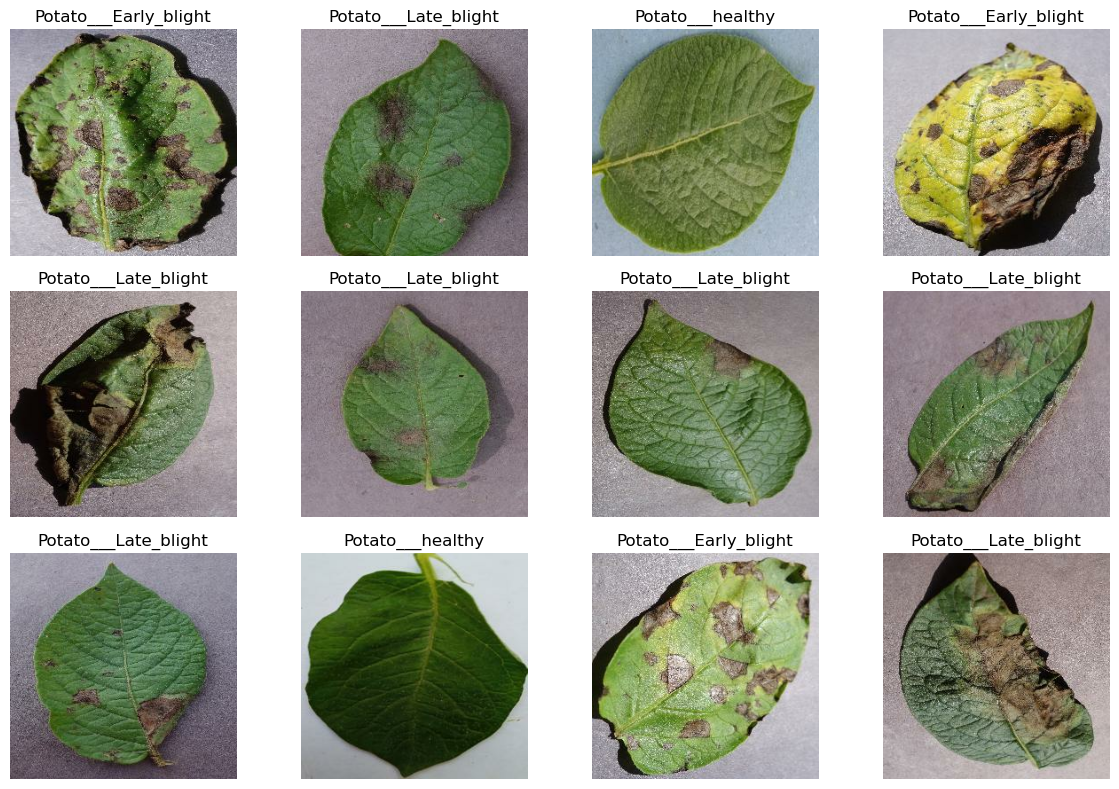

Image batch shape: (32, 256, 256, 3)
Labels batch: [0 1 2 0 1 1 1 1 1 2 0 1]


In [11]:
plt.figure(figsize=(12, 8))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(min(12, BATCH_SIZE)):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Image batch shape: {image_batch.shape}")
print(f"Labels batch: {labels_batch.numpy()[:12]}")

## 5. Data Preprocessing & Augmentation Pipeline
**CORRECT ORDER**: Rescaling → Augmentation → Cache → Prefetch

In [ ]:
# Rescaling layer (normalize to [0, 1])
from tensorflow.keras.layers import Rescaling, Resizing

resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),  # Normalize pixel values to [0, 1]
], name='resize_and_rescale')

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.3),  # Increased from 0.2
    RandomZoom(0.2),      # Added zoom
    RandomContrast(0.2),  # Added contrast
], name='data_augmentation')

✅ Preprocessing and augmentation layers created


## 6. Apply Preprocessing in CORRECT Order
Apply augmentation → then cache → then prefetch

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Apply augmentation to training data BEFORE caching
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Validation and test datasets only need cache and prefetch (no augmentation)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Data pipeline configured correctly
   Training: Augmentation → Cache → Shuffle → Prefetch
   Validation/Test: Cache → Prefetch


## 7. Build IMPROVED Model Architecture
**Fixes:**
- Removed BATCH_SIZE from input_shape
- Reduced pooling layers from 6 to 4
- Progressive filter increase: 32→64→128→256
- Added Dropout for regularization
- Added BatchNormalization

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout


model = models.Sequential([
   
    resize_and_rescale,
    
    # Block 1: 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Block 2: 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Block 3: 128 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Block 4: 256 filters
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Block 5: 256 filters (deeper)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax'),
], name='potato_disease_cnn')

✅ Model architecture created


In [ ]:

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()

Model: "potato_disease_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize_and_rescale (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,792,195 (67.87 MB)

 Trainable params: 17,790,723 (67.87 MB)

 Non-trainable params: 1,472 (5.75 KB)

## 8. Compile Model with Callbacks
**Added:**
- Early Stopping (patience=15)
- Model Checkpoint (save best model)
- Learning Rate Reduction (on plateau)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


checkpoint_dir = r"c:\Users\sarva\Downloads\Minor-project\checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

callbacks = [
    
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

✅ Model compiled with callbacks:
   - Early Stopping (patience=15)
   - Model Checkpoint (save best)
   - Learning Rate Reduction (factor=0.5, patience=5)


## 9. Train the Model
Training with 100 epochs and callbacks

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

🚀 Starting training...
Training for up to 100 epochs
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7059 - loss: 4.0485

KeyboardInterrupt: 

## 10. Evaluate Model on Test Set

In [ ]:
print("Evaluating model on test set...")
scores = model.evaluate(test_ds, verbose=1)

print("\nTEST SET RESULTS:")
print(f"  Test Loss: {scores[0]:.4f}")
print(f"  Test Accuracy: {scores[1]*100:.2f}%")

## 11. Visualize Training History

In [ ]:

actual_epochs = len(history.history['accuracy'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(actual_epochs), acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(actual_epochs), val_acc, 'r-', label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(actual_epochs), loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(actual_epochs), val_loss, 'r-', label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"  Epochs trained: {actual_epochs}/{EPOCHS}")
print(f"  Final training accuracy: {acc[-1]*100:.2f}%")
print(f"  Final validation accuracy: {val_acc[-1]*100:.2f}%")
print(f"  Best validation accuracy: {max(val_acc)*100:.2f}%")

## 12. Test Single Prediction (FIXED function)
**Fixed the undefined variable 'i' bug**

In [ ]:
# Test prediction on a single batch
for images_batch, labels_batch in test_ds.take(1):
    
    
    test_idx = 3
    first_image = images_batch[test_idx].numpy().astype('uint8')
    first_label = labels_batch[test_idx].numpy()
    
    print("Testing single prediction...")
    plt.figure(figsize=(6, 6))
    plt.imshow(first_image)
    plt.axis('off')
    
    
    batch_prediction = model.predict(images_batch, verbose=0)
    predicted_class_idx = np.argmax(batch_prediction[test_idx])
    confidence = np.max(batch_prediction[test_idx]) * 100
    
    print(f"  Actual: {class_names[first_label]}")
    print(f"  Predicted: {class_names[predicted_class_idx]}")
    print(f"  Confidence: {confidence:.2f}%")
    
    plt.title(f"Actual: {class_names[first_label]}\nPredicted: {class_names[predicted_class_idx]} ({confidence:.1f}%)")
    plt.show()
    
    break

## 13. Correct Prediction Function
**Fixed version without undefined 'i' variable**

In [ ]:
def predict_image(model, image, class_names):
    """
    Predict disease class for a single image
    
    Args:
        model: Trained Keras model
        image: Single image tensor (should be from dataset batch)
        class_names: List of class names
    
    Returns:
        predicted_class: String name of predicted class
        confidence: Confidence percentage
    """
   
    img_array = image.numpy() if hasattr(image, 'numpy') else image
    
   
    if len(img_array.shape) == 3:
        img_array = tf.expand_dims(img_array, 0)
    
    
    predictions = model.predict(img_array, verbose=0)
    
   
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

## 14. Visualize Multiple Predictions
Test the fixed prediction function on 9 images

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
   
        predicted_class, confidence = predict_image(model, images[i], class_names)
        actual_class = class_names[labels[i]]
        
        
        color = 'green' if predicted_class == actual_class else 'red'
        
        plt.title(
            f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%",
            color=color,
            fontsize=10
        )
        plt.axis("off")

plt.tight_layout()
plt.show()

## 15. Comprehensive Model Evaluation
Calculate precision, recall, F1-score, and confusion matrix

In [ ]:
print("Running comprehensive evaluation...")


y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch, verbose=0)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

print("\nEVALUATION METRICS:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nCLASSIFICATION REPORT:")
print(report)
print("\nCONFUSION MATRIX:")
print(cm)

## 16. Visualize Confusion Matrix

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Potato Disease Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
    print(f"  {class_name}: {class_accuracy:.2f}%")

## 17. Save Model
Save to the same location as original (auto-increment version number)

In [ ]:
save_dir = r"c:\Users\sarva\Downloads\Minor-project\models"
os.makedirs(save_dir, exist_ok=True)

existing_versions = [int(i) for i in os.listdir(save_dir) if i.isdigit()]
model_version = max(existing_versions + [0]) + 1
model_path = os.path.join(save_dir, str(model_version))


print(f"\nSaving model to: {model_path}")
model.export(model_path)

print("\nMODEL SAVED SUCCESSFULLY!")
print(f"Model Version: {model_version}")
print(f"Save Path: {model_path}")
print(f"Test Accuracy: {scores[1]*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print(f"\nTo use this model in TensorFlow Serving:")
print(f"docker run -d -p 8501:8501 \\")
print(f"  --mount type=bind,source={model_path},target=/models/potatoes_model/1 \\")
print(f"  -e MODEL_NAME=potatoes_model -t tensorflow/serving")